In [2]:
import os, numpy as np, trimesh, open3d as o3d, matplotlib.pyplot as plt
from scipy.spatial import KDTree

BASE_DIR = "bonus/option2/girl_outputs"
subdirs = ["transformed", "normalized", "quantized", "reconstructed", "plots"]
for s in subdirs:
    os.makedirs(os.path.join(BASE_DIR, s), exist_ok=True)

print("Directory structure ready under", os.path.abspath(BASE_DIR))


Directory structure ready under c:\Users\user\Desktop\mesh_Assignment\bonus\option2\girl_outputs


In [3]:
mesh = trimesh.load("meshes/girl.obj", process=False)
V_orig = np.asarray(mesh.vertices)
F = mesh.faces
print("Vertices:", V_orig.shape[0])
mesh.show()


Vertices: 8400


In [10]:
from trimesh.transformations import rotation_matrix, translation_matrix

def make_transforms():
    transforms = []
    # rotation about X/Y/Z axes (30°, 45°, 60°)
    for angle in [30, 45, 60]:
        rad = np.deg2rad(angle)
        R = rotation_matrix(rad, [1,0,0]) @ rotation_matrix(rad/2, [0,1,0])
        T = translation_matrix(np.random.uniform(-0.5, 0.5, size=3))
        transforms.append(R @ T)
    return transforms

transforms = make_transforms()
meshes_trans = []

for i, T in enumerate(transforms):
    m_copy = mesh.copy().apply_transform(T)
    out = os.path.join(BASE_DIR, "transformed", f"girl_trans_{i}.obj")
    m_copy.export(out)
    meshes_trans.append(m_copy)
    print(f"Saved transformed mesh {i} → {out}")

Saved transformed mesh 0 → bonus/option2/girl_outputs\transformed\girl_trans_0.obj
Saved transformed mesh 1 → bonus/option2/girl_outputs\transformed\girl_trans_1.obj
Saved transformed mesh 2 → bonus/option2/girl_outputs\transformed\girl_trans_2.obj


In [5]:
def invariant_normalize(V):
    centroid = V.mean(axis=0)
    Vc = V - centroid
    scale = np.max(np.linalg.norm(Vc, axis=1))
    scale = 1.0 if scale == 0 else scale
    return Vc / scale, {"centroid": centroid, "scale": scale}

In [6]:
def adaptive_quantize(V_norm, bins_global=1024, k=8):
    # local density → mean distance to k nearest neighbors
    tree = KDTree(V_norm)
    dists, _ = tree.query(V_norm, k=k)
    local_density = np.mean(dists, axis=1)
    # normalize densities into [0.5, 1.5] range (dense→smaller bins)
    density_scale = 1.5 - (local_density / local_density.max())
    q_values = []
    for i, v in enumerate(V_norm):
        local_bins = int(bins_global * density_scale[i])
        local_bins = max(64, min(local_bins, bins_global))
        q = np.floor(v * (local_bins - 1)) / (local_bins - 1)
        q_values.append(q)
    return np.array(q_values)

In [7]:
results = []
for i, m in enumerate(meshes_trans):
    V = np.asarray(m.vertices)

    # Normalize (rotation + translation invariant)
    Vn, ctx = invariant_normalize(V)
    m_norm = trimesh.Trimesh(vertices=Vn, faces=F)
    norm_path = os.path.join(BASE_DIR, "normalized", f"girl_norm_{i}.obj")
    m_norm.export(norm_path)

    # Adaptive quantization
    Vq = adaptive_quantize(Vn)
    q_path = os.path.join(BASE_DIR, "quantized", f"girl_quant_{i}.obj")
    trimesh.Trimesh(vertices=Vq, faces=F).export(q_path)

    # Reconstruct
    V_rec = Vq * ctx["scale"] + ctx["centroid"]
    rec_path = os.path.join(BASE_DIR, "reconstructed", f"girl_recon_{i}.obj")
    trimesh.Trimesh(vertices=V_rec, faces=F).export(rec_path)

    # Error metrics
    mae = np.mean(np.abs(V - V_rec))
    mse = np.mean((V - V_rec)**2)
    results.append([i, mae, mse])
    print(f"Transform {i} → MAE={mae:.6e}, MSE={mse:.6e}")

Transform 0 → MAE=2.625232e-04, MSE=9.248154e-08
Transform 1 → MAE=2.619639e-04, MSE=9.196745e-08
Transform 2 → MAE=2.594145e-04, MSE=9.055531e-08


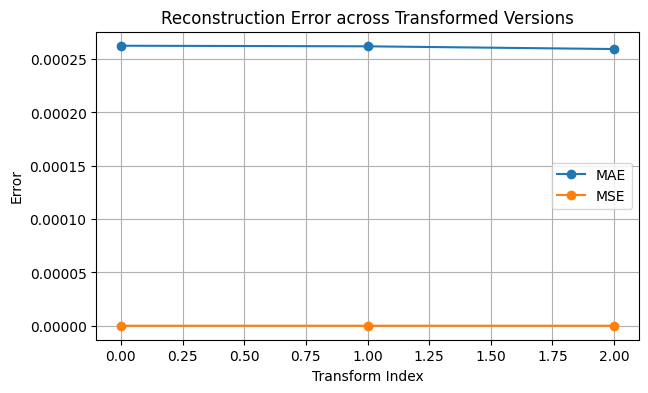

In [8]:
ids = [r[0] for r in results]
mae = [r[1] for r in results]
mse = [r[2] for r in results]

plt.figure(figsize=(7,4))
plt.plot(ids, mae, "o-", label="MAE")
plt.plot(ids, mse, "o-", label="MSE")
plt.title("Reconstruction Error across Transformed Versions")
plt.xlabel("Transform Index")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(BASE_DIR, "plots", "error_adaptive.png"))
plt.show()

In [9]:
print("Average MAE:", np.mean(mae))
print("Average MSE:", np.mean(mse))

Average MAE: 0.0002613005284051977
Average MSE: 9.166809945451616e-08


In [ ]:
import os, numpy as np, trimesh, matplotlib.pyplot as plt
from trimesh.transformations import rotation_matrix, translation_matrix
from scipy.spatial import KDTree

mesh_names = ["branch", "cylinder", "explosive", "fence", "girl", "person", "table", "talwar"]
base_dir = "bonus/option2"
num_transforms = 3          # how many random transforms per mesh
bins_global = 1024          # global max bins for adaptive quantization


def make_transforms(n=3):
    transforms = []
    for i in range(n):
        ang = np.deg2rad(np.random.uniform(20, 60))
        R = rotation_matrix(ang, np.random.rand(3))
        T = translation_matrix(np.random.uniform(-0.5, 0.5, 3))
        transforms.append(R @ T)
    return transforms

def invariant_normalize(V):
    centroid = V.mean(axis=0)
    Vc = V - centroid
    scale = np.max(np.linalg.norm(Vc, axis=1))
    scale = 1.0 if scale == 0 else scale
    return Vc / scale, {"centroid": centroid, "scale": scale}

def adaptive_quantize(V_norm, bins_global=1024, k=8):
    tree = KDTree(V_norm)
    dists, _ = tree.query(V_norm, k=k)
    local_density = np.mean(dists, axis=1)
    density_scale = 1.5 - (local_density / local_density.max())
    q_values = []
    for i, v in enumerate(V_norm):
        local_bins = int(bins_global * density_scale[i])
        local_bins = max(64, min(local_bins, bins_global))
        q = np.floor(v * (local_bins - 1)) / (local_bins - 1)
        q_values.append(q)
    return np.array(q_values)

def process_mesh(name):
    mesh_path = f"meshes/{name}.obj"
    mesh = trimesh.load(mesh_path, process=False)
    V, F = np.asarray(mesh.vertices), mesh.faces

    BASE = os.path.join(base_dir, f"{name}_outputs")
    subdirs = ["transformed","normalized","quantized","reconstructed","plots"]
    for s in subdirs:
        os.makedirs(os.path.join(BASE, s), exist_ok=True)

    transforms = make_transforms(num_transforms)
    results = []

    for i, T in enumerate(transforms):
        m_copy = mesh.copy().apply_transform(T)
        m_copy.export(os.path.join(BASE,"transformed",f"{name}_trans_{i}.obj"))

        Vn, ctx = invariant_normalize(np.asarray(m_copy.vertices))
        trimesh.Trimesh(vertices=Vn, faces=F).export(os.path.join(BASE,"normalized",f"{name}_norm_{i}.obj"))

        Vq = adaptive_quantize(Vn, bins_global=bins_global)
        trimesh.Trimesh(vertices=Vq, faces=F).export(os.path.join(BASE,"quantized",f"{name}_quant_{i}.obj"))

        V_rec = Vq * ctx["scale"] + ctx["centroid"]
        trimesh.Trimesh(vertices=V_rec, faces=F).export(os.path.join(BASE,"reconstructed",f"{name}_recon_{i}.obj"))

        mae = np.mean(np.abs(np.asarray(m_copy.vertices) - V_rec))
        mse = np.mean((np.asarray(m_copy.vertices) - V_rec) ** 2)
        results.append([i, mae, mse])

    ids, mae_vals, mse_vals = zip(*results)
    plt.figure(figsize=(6,4))
    plt.plot(ids, mae_vals, "o-", label="MAE")
    plt.plot(ids, mse_vals, "o-", label="MSE")
    plt.title(f"{name} – Reconstruction Error (Adaptive Quantization)")
    plt.xlabel("Transform Index")
    plt.ylabel("Error")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(BASE,"plots",f"{name}_error.png"))
    plt.close()

    avg_mae, avg_mse = np.mean(mae_vals), np.mean(mse_vals)
    print(f"✅ {name}: MAE={avg_mae:.6e}, MSE={avg_mse:.6e}")
    return name, avg_mae, avg_mse

summary = [process_mesh(name) for name in mesh_names]

import pandas as pd
df = pd.DataFrame(summary, columns=["Mesh","Avg_MAE","Avg_MSE"])
print("\n=== Adaptive Quantization Summary ===")
display(df)
df.to_csv(os.path.join(base_dir,"adaptive_summary.csv"), index=False)


✅ branch: MAE=6.700537e-04, MSE=6.020994e-07
✅ cylinder: MAE=1.383771e-03, MSE=2.526721e-06
✅ explosive: MAE=2.691471e-04, MSE=9.683731e-08
✅ fence: MAE=3.128669e-04, MSE=1.326662e-07
✅ girl: MAE=2.616877e-04, MSE=9.186683e-08
✅ person: MAE=5.830524e-04, MSE=4.540835e-07
✅ table: MAE=3.045377e-04, MSE=1.243399e-07
✅ talwar: MAE=3.505468e-04, MSE=1.638824e-07

=== Adaptive Quantization Summary ===


,Mesh,Avg_MAE,Avg_MSE
0,branch,0.000670,6.020994e-07
1,cylinder,0.001384,2.526721e-06
2,explosive,0.000269,9.683731e-08
3,fence,0.000313,1.326662e-07
4,girl,0.000262,9.186683e-08
5,person,0.000583,4.540835e-07
6,table,0.000305,1.243399e-07
7,talwar,0.000351,1.638824e-07


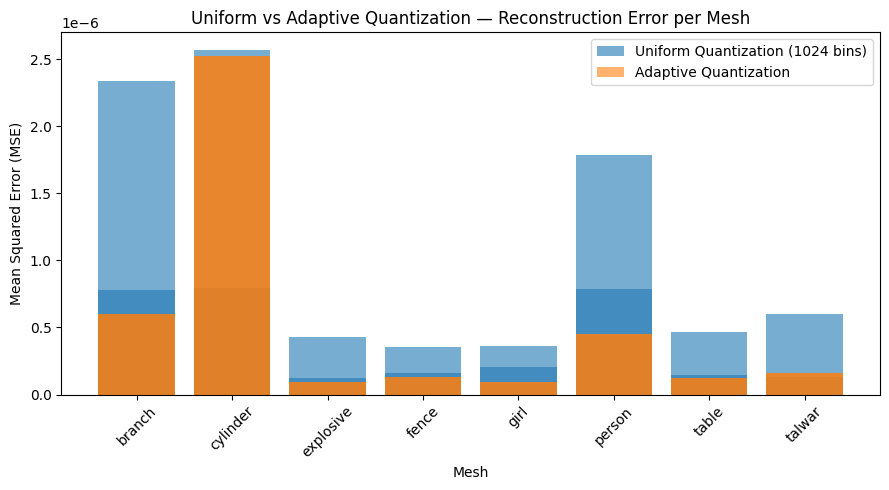

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load both result summaries
uniform = pd.read_csv("outputs/summary.csv")           # from Task 3
adaptive = pd.read_csv("bonus/option2/adaptive_summary.csv")

# Ensure column names align
uniform = uniform.rename(columns={"mse_all": "Uniform_MSE"})
adaptive = adaptive.rename(columns={"Avg_MSE": "Adaptive_MSE"})

# Merge both by mesh name
merged = pd.merge(uniform[["mesh", "Uniform_MSE"]], adaptive[["Mesh", "Adaptive_MSE"]],
                  left_on="mesh", right_on="Mesh", how="inner")

# Create comparison plot
plt.figure(figsize=(9,5))
plt.bar(merged["mesh"], merged["Uniform_MSE"], alpha=0.6, label="Uniform Quantization (1024 bins)")
plt.bar(merged["mesh"], merged["Adaptive_MSE"], alpha=0.6, label="Adaptive Quantization")
plt.title("Uniform vs Adaptive Quantization — Reconstruction Error per Mesh")
plt.ylabel("Mean Squared Error (MSE)")
plt.xlabel("Mesh")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Save and show
os.makedirs("bonus/option2", exist_ok=True)
plt.savefig("bonus/option2/error_comparison.png")
plt.show()


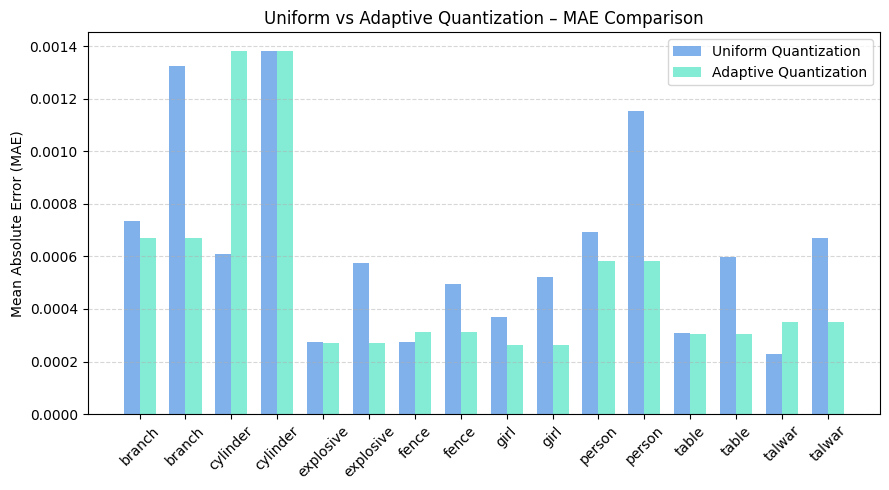

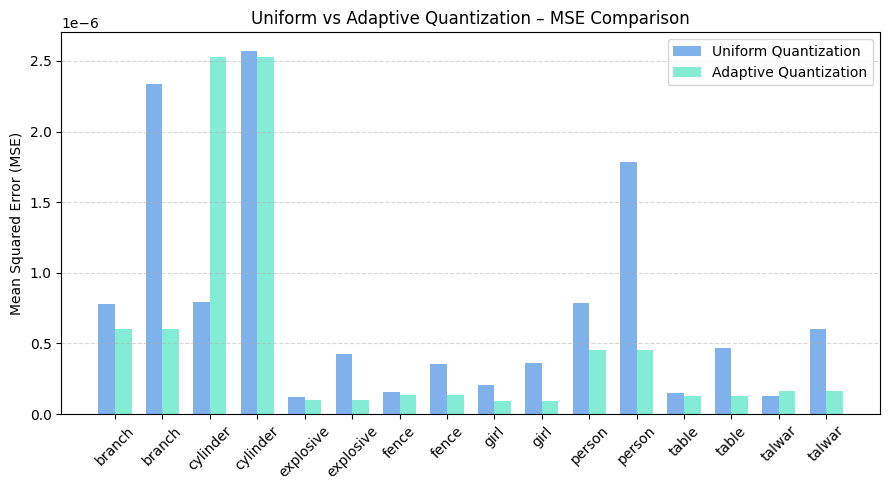

✅ Saved plots:
bonus/option2/plots/mae_comparison.png
bonus/option2/plots/mse_comparison.png


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Load data
uniform = pd.read_csv("outputs/summary.csv")
adaptive = pd.read_csv("bonus/option2/adaptive_summary.csv")

# Rename for clarity
uniform = uniform.rename(columns={"mesh": "Mesh", "mae_all": "Uniform_MAE", "mse_all": "Uniform_MSE"})
adaptive = adaptive.rename(columns={"Avg_MAE": "Adaptive_MAE", "Avg_MSE": "Adaptive_MSE"})

# Merge both
merged = pd.merge(uniform[["Mesh", "Uniform_MAE", "Uniform_MSE"]],
                  adaptive[["Mesh", "Adaptive_MAE", "Adaptive_MSE"]],
                  on="Mesh")

# Create output folder
os.makedirs("bonus/option2/plots", exist_ok=True)

# -------------------------------
# Plot 1: MAE Comparison
# -------------------------------
x = np.arange(len(merged["Mesh"]))
width = 0.35

plt.figure(figsize=(9,5))
plt.bar(x - width/2, merged["Uniform_MAE"], width, label="Uniform Quantization", color="#4a90e2", alpha=0.7)
plt.bar(x + width/2, merged["Adaptive_MAE"], width, label="Adaptive Quantization", color="#50e3c2", alpha=0.7)
plt.xticks(x, merged["Mesh"], rotation=45)
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Uniform vs Adaptive Quantization – MAE Comparison")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("bonus/option2/plots/mae_comparison.png", dpi=300)
plt.show()

# -------------------------------
# Plot 2: MSE Comparison
# -------------------------------
plt.figure(figsize=(9,5))
plt.bar(x - width/2, merged["Uniform_MSE"], width, label="Uniform Quantization", color="#4a90e2", alpha=0.7)
plt.bar(x + width/2, merged["Adaptive_MSE"], width, label="Adaptive Quantization", color="#50e3c2", alpha=0.7)
plt.xticks(x, merged["Mesh"], rotation=45)
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Uniform vs Adaptive Quantization – MSE Comparison")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("bonus/option2/plots/mse_comparison.png", dpi=300)
plt.show()

print("✅ Saved plots:")
print("bonus/option2/plots/mae_comparison.png")
print("bonus/option2/plots/mse_comparison.png")
